In [6]:
import numpy as np
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
sigma_psf = 2.0
sources = Table()
sources['flux'] = [700, 800, 700, 800]
sources['x_mean'] = [12, 17, 12, 17]
sources['y_mean'] = [15, 15, 20, 20]
sources['x_stddev'] = sigma_psf*np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0, 0, 0, 0]
sources['id'] = [1, 2, 3, 4]
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, distribution='poisson', mean=6.,
                          seed=123) +
         make_noise_image(tshape, distribution='gaussian', mean=0.,
                          stddev=2., seed=123))

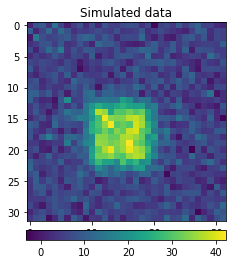

In [7]:
from matplotlib import rcParams
rcParams['font.size'] = 13
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(image)  
plt.title('Simulated data')  
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)  


In [8]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm


In [9]:
bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11,11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

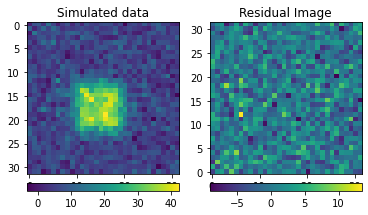

In [10]:
plt.subplot(1, 2, 1)

plt.imshow(image, cmap='viridis', aspect=1, interpolation='nearest')

plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1 ,2, 2)
           
plt.imshow(residual_image, cmap='viridis', aspect=1,
           interpolation='nearest', origin='lower')
           
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()